Bilayer exciton condensation in Landau levels with total filling factor 1.

In [1]:
# These packages are not included in the MomentumED package. 
# Use the following line to add them:
# using Pkg; Pkg.add("CairoMakie"); Pkg.add("QuadGK"); Pkg.add("ClassicalOrthogonalPolynomials")

# Import the momentum-conserved exact diagonalization package
using MomentumED, LinearAlgebra
include("../Landau level torus.jl")
using .LLT

# square/triangular lattice
sqa_lattice = ReciprocalLattice(:square);          # == ReciprocalLattice(1, 0)
tri_lattice = ReciprocalLattice(:triangular);      # == ReciprocalLattice(1, -1//2)
# general_lattice = ReciprocalLattice(abs(G2/G1), cos(θ))
# use exact values, Integer or Rational, to avoid uncertainty on Brillouin Zone boundary.

using CairoMakie # for plotting
CairoMakie.activate!()

# Plot the energy spectrum
function plot_ed_spectrum(energies, ss_k1, ss_k2; 
    title = nothing, ylims = (nothing, nothing),
    ylabel = "Energy per unit cell (W₀ = e²/ϵl)",
)
    fig = Figure();
    ax = Axis(fig[1, 1];
        xlabel = "$(Gk[2])k1+k2",
        ylabel = ylabel
    )
    ax_top = Axis(fig[1, 1];
        xaxisposition = :top
    )
    top_ticks = ([], [])
    hidespines!(ax_top)
    hidexdecorations!(ax_top; label = false, ticklabels = false)
    hideydecorations!(ax_top)
    linkxaxes!(ax, ax_top)

    # Plot energy levels for each momentum block
    for i in 1:length(ss_k1)
        x = Gk[2] * ss_k1[i] + ss_k2[i]
        push!(top_ticks[1], x)
        push!(top_ticks[2], string(i))
        if isassigned(energies,i)
            for e in energies[i]
                scatter!(ax, x, e/Nk/LLT.W0, color = :blue, marker=:hline)
            end
        end
    end
    ylims!(ax, ylims...)
    ax_top.xticks = top_ticks
    if title isa String
        ax_top.subtitle = title
    end
    display(fig)
    fig
end

function plot_entanglement_spectrum(;title=nothing, ylims = (nothing, nothing))
    fig = Figure();
    ax = Axis(fig[1,1];
        xlabel = "Ne in A-part",
        xticksvisible = false,
        xgridvisible = false,
        xminorgridvisible = true,
    )

    x = 0
    NA_lines = Float64[-0.5;]
    xtickposition = Float64[];
    xticklabel = String[];
    for indexNA in CartesianIndices(entanglement_spectrum)
        x_begin = x
        for (indexkA, spectrum) in enumerate(entanglement_spectrum[indexNA])
            if !isempty(spectrum)
                for e in spectrum
                    scatter!(ax, x, e, color = :blue, marker=:hline)
                end
                x += 1
            end
        end
        x_end = x
        if x_end > x_begin
            NA = string(indexNA[1]-1)
            for i in 2:length(indexNA)
                NA *= ",$(indexNA[i]-1)"
            end
            push!(xtickposition, 0.5(x_begin+x_end-1))
            push!(xticklabel, NA)
            push!(NA_lines, x-0.5)
        end
    end
    ax.xticks = (xtickposition, xticklabel)
    ax.xminorticks = NA_lines
    if title isa String
        ax.subtitle = title
    end
    ylims!(ax, ylims...)
    display(fig)
    fig
end

plot_entanglement_spectrum (generic function with 1 method)

In [2]:
# Define k-mesh for bilayer system (4×3 mesh, Nk=12) in triangular lattice
k_list = [0 1 2 3 0 1 2 3 0 1 2 3;
          0 0 0 0 1 1 1 1 2 2 2 2]
Nk = 12
Gk = (4, 3)  # Grid dimensions


# Number of layers (components) for bilayer system
Nc_conserve = 2

2

In [3]:
# Set up one-body Hamiltonian matrix for inter-layer tunneling
ΔE = 0.0 * LLT.W0                # Energy difference between the two layers

# H_onebody[c1, c2, cc, k] : no hopping from component c2 to c1
# For bilayer system: Nc_hopping=1, Nc_conserve=2, No tunneling
H_onebody_bilayer_no_tunneling = zeros(ComplexF64, 1, 1, Nc_conserve, Nk)
for k_idx in 1:Nk
    H_onebody_bilayer_no_tunneling[1, 1, 1, k_idx] = 0.5ΔE
    H_onebody_bilayer_no_tunneling[1, 1, 2, k_idx] = -0.5ΔE
end

# Set up component parameters: (layer, level, Chern number, pseudospin)
sys_int = LandauInteraction(
    tri_lattice,
    # ReciprocalLattice(5//3, 1//10),  # use some random lattice to avoid CDW phase
    (1, 0, 1, 0),
    (2, 0, 1, 0)
);

In [64]:
# Interaction parameters

# Coulomb
sys_int.D_l = 10.0                  # Screening length D/l
sys_int.d_l = 0.0                   # Inter-layer distance d/l
# compute the pseudo-potential components
intra_PP = LLT.pseudo_potential_decomposition.(0:10; same_layer = true,  D_l = sys_int.D_l, d_l = sys_int.d_l)
inter_PP = LLT.pseudo_potential_decomposition.(0:10; same_layer = false, D_l = sys_int.D_l, d_l = sys_int.d_l)
@show intra_PP
@show inter_PP

# Haldane pseudo-potential
# sys_int.V_intra = [0.0; 0.8; 0.0; 0.4]          # Intralayer Haldane pseudo-potential in unit of W0
# sys_int.V_inter = [1.0; 0.7; 0.5; 0.4]          # Interlayer Haldane pseudo-potential in unit of W0

# or use Coulomb interaction with a cutoff in m
sys_int.V_intra = copy(intra_PP)
sys_int.V_inter = copy(inter_PP)

# choose a linear mixing between Haldane and Coulomb interaction
sys_int.mix = 0                  # mix * Haldane + (1-mix) * Coulomb

# Create parameter structure for bilayer system
para_conserve = EDPara(
    k_list = k_list, 
    Gk = Gk, 
    Nc_hopping = 1,
    Nc_conserve = Nc_conserve,
    H_onebody = H_onebody_bilayer_no_tunneling,
    V_int = sys_int,
    FF_inf_angle = LLT.Landau_ff_inf(sys_int),
);

intra_PP = [1.634711735356748, 0.749358256026894, 0.5286614325145934, 0.41872976155450814, 0.3503270791671362, 0.3026827462193143, 0.2671424975972047, 0.23937933875941908, 0.21695945116067117, 0.1983956001259201, 0.18272116857187637]
inter_PP = [1.634711735356748, 0.749358256026894, 0.5286614325145934, 0.41872976155450814, 0.3503270791671362, 0.3026827462193143, 0.2671424975972047, 0.23937933875941908, 0.21695945116067117, 0.1983956001259201, 0.18272116857187637]


In [65]:
# number of electrons in each layer
Ne1 = 1
Ne2 = 11
Ne = (Ne1, Ne2)

(1, 11)

In [66]:
NG = 2
index_shift = NG .* Gk .+ 1
densities = MBOperator[density_operator(q1, q2, lf, li; 
        para = para_conserve, form_factor = true)
    for q1 in -NG*Gk[1]:NG*Gk[1], q2 in -NG*Gk[2]:NG*Gk[2], lf = 1:2, li=1:2
];
function structure_factor_expectation(myvec)
    structure_factor = similar(densities, ComplexF64)
    for q1 in -NG*Gk[1]:NG*Gk[1], q2 in -NG*Gk[2]:NG*Gk[2]
        for lf = 1:2, li = 1:2
            structure_factor[index_shift[1]+q1, index_shift[2]+q2, lf, li] = 
                ED_bracket_threaded(myvec, 
                    densities[index_shift[1]-q1, index_shift[2]-q2, li, lf], 
                    densities[index_shift[1]+q1, index_shift[2]+q2, lf, li], myvec
                )
            if mod(q1, Gk[1]) == 0 && mod(q2, Gk[2])== 0 && lf==li
                structure_factor[index_shift[1]+q1, index_shift[2]+q2, lf, li] -= 
                    ED_bracket_threaded(myvec, densities[index_shift[1]-q1, index_shift[2]-q2, li, lf], myvec) * 
                    ED_bracket_threaded(myvec, densities[index_shift[1]+q1, index_shift[2]+q2, lf, li], myvec)
            end
        end
    end
    structure_factor ./= Nk
end

structure_factor_expectation (generic function with 1 method)

In [67]:
# Create momentum blocks (Hilbert subspace) for bilayer system
subspaces, ss_k1, ss_k2 = ED_momentum_subspaces(para_conserve, (Ne1, Ne2));
display(length.(subspaces))

# Generate Scatter lists for efficient Hamiltonian construction
scat_list1_conserve = ED_sortedScatterList_onebody(para_conserve);
scat_list2_conserve = ED_sortedScatterList_twobody(para_conserve);

12-element Vector{Int64}:
 12
 12
 12
 12
 12
 12
 12
 12
 12
 12
 12
 12

In [68]:
Neigen = 10  # Number of eigenvalues to compute per subspace
energies = Vector{Vector{Float64}}(undef, length(subspaces));
vectors = Vector{Vector{<:MBS64Vector}}(undef, length(subspaces));
for i in eachindex(subspaces)
    println("Processing subspace #$i with size $(length(subspaces[i])), momentum $(ss_k1[i]), $(ss_k2[i])")
    energies[i], vectors[i] = EDsolve(subspaces[i], scat_list2_conserve, scat_list1_conserve;
        N=Neigen, showtime=true, ishermitian=true
    )
end

Processing subspace #1 with size 12, momentum 0, 0
  0.000463 seconds (564 allocations: 178.727 KiB)
  0.042047 seconds (17.76 k allocations: 910.729 KiB, 92.84% compilation time)
Processing subspace #2 with size 12, momentum 0, 1
  0.001946 seconds (232 allocations: 136.708 KiB)
  0.000060 seconds (28 allocations: 17.300 KiB)
Processing subspace #3 with size 12, momentum 0, 2
  0.001946 seconds (251 allocations: 159.720 KiB)
  0.000045 seconds (28 allocations: 17.347 KiB)
Processing subspace #4 with size 12, momentum 1, 0
  0.001241 seconds (251 allocations: 159.688 KiB)
  0.000039 seconds (28 allocations: 17.347 KiB)
Processing subspace #5 with size 12, momentum 1, 1
  0.002473 seconds (226 allocations: 119.750 KiB)
  0.000042 seconds (28 allocations: 17.362 KiB)
Processing subspace #6 with size 12, momentum 1, 2
  0.001959 seconds (251 allocations: 159.642 KiB)
  0.000050 seconds (28 allocations: 17.347 KiB)
Processing subspace #7 with size 12, momentum 2, 0
  0.001962 seconds (245 

┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:121
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:121
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:121
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:121
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:121
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\Momentu

  0.001319 seconds (264 allocations: 165.867 KiB)
  0.000036 seconds (28 allocations: 17.300 KiB)


In [69]:
# check energies explicitly to see degeneracy.

sn = 7 # the subspace number to inspect
println("total momentum: ", ss_k1[sn], "  ", ss_k2[sn])
energies[sn]/Nk/LLT.W0

total momentum: 2  0


10-element Vector{Float64}:
 4.1772077002625565
 4.244224003331595
 4.244224003331597
 4.245584654686225
 4.245584654686226
 4.245731694408547
 4.245731694408549
 4.255847406545328
 4.255847406545331
 4.2575421620122915

Plot the spectrums for different layer fillings with total filling 1, and calculate their structure factors

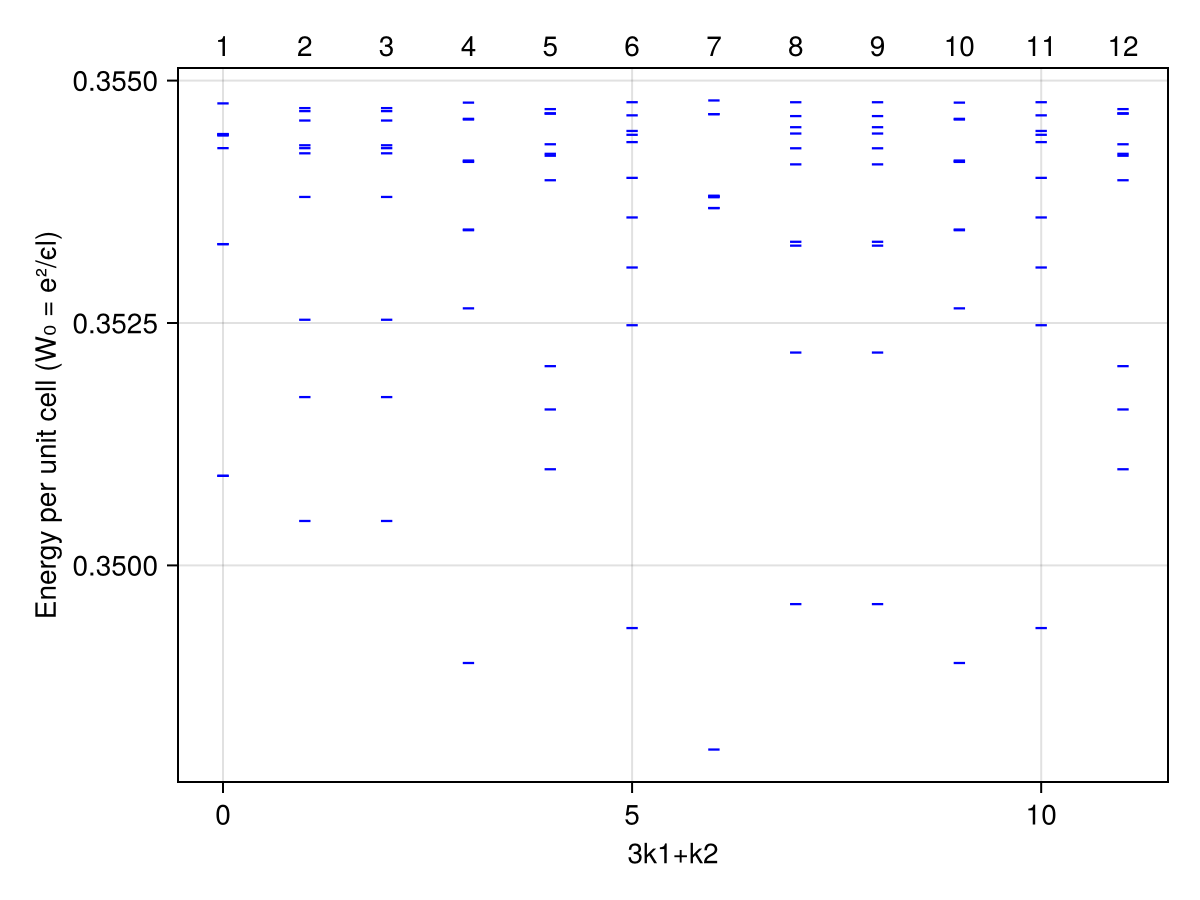

((energies[7])[1] / Nk) / LLT.W0 = 4.1772077002625565
  0.097631 seconds (82.85 k allocations: 5.313 MiB, 36.07% compilation time)
maximum(abs.(imag.(str_fac210))) = 2.0238440553062766e-18
extrema(real.(str_fac210)) = (-1.3234889800848243e-22, 1.8333333333333328)
str_fac210[index_shift..., 1, 2] = 1.8333333333333328 + 0.0im
str_fac210[index_shift..., 2, 1] = 0.9999999999999996 + 0.0im


In [70]:
plot_ed_spectrum(energies/Nk/LLT.W0, ss_k1, ss_k2) # 2, 10
@show energies[7][1]/Nk/LLT.W0
myvec210 = vectors[7][1]
@time str_fac210 = structure_factor_expectation(myvec210);
@show maximum(abs.(imag.(str_fac210)));
@show extrema(real.(str_fac210));
@show str_fac210[index_shift..., 1,2];
@show str_fac210[index_shift..., 2,1];

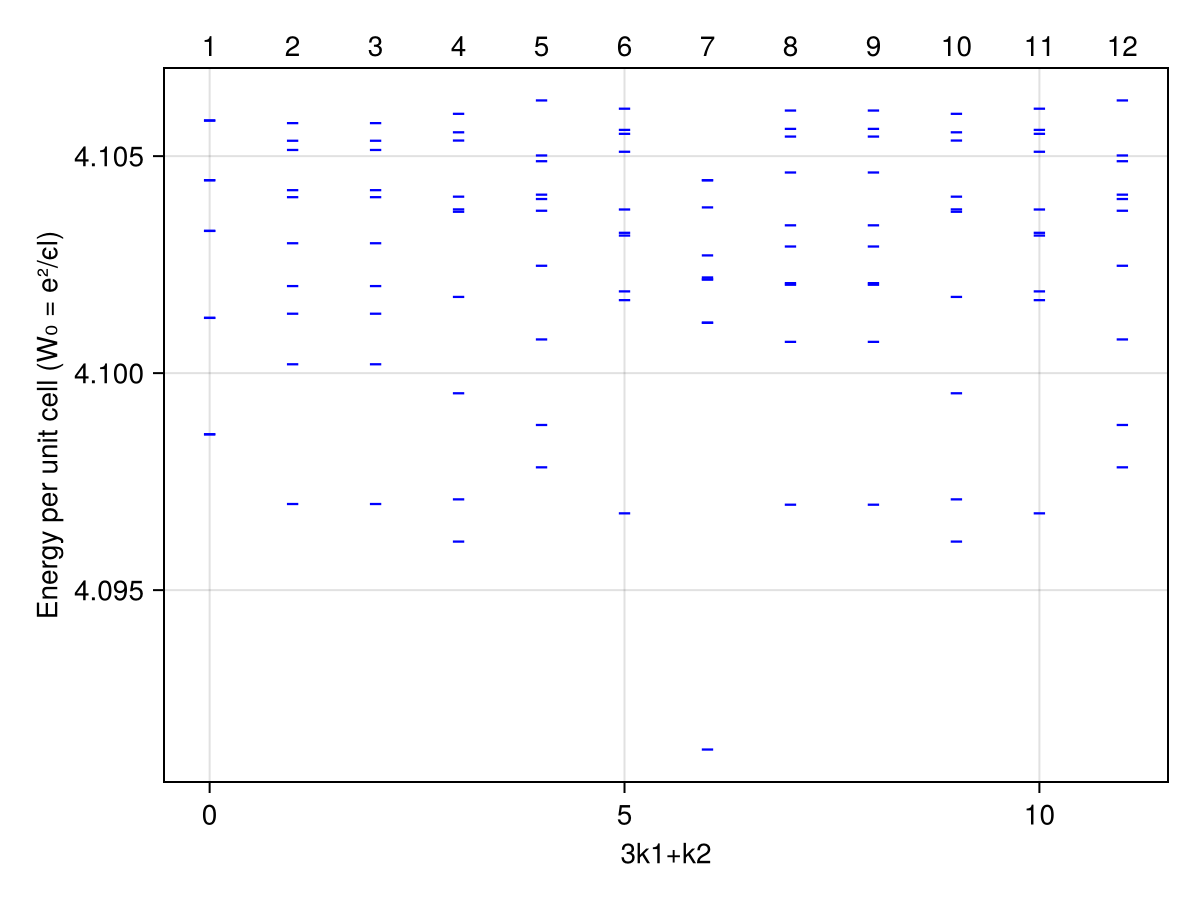

((energies[7])[1] / Nk) / LLT.W0 = 4.091325902581695
  0.976375 seconds (86.09 k allocations: 5.382 MiB, 3.90% compilation time)
maximum(abs.(imag.(str_fac39))) = 2.3234753978825475e-18
extrema(real.(str_fac39)) = (8.142215382592098e-21, 2.562684755779023)
str_fac39[index_shift..., 1, 2] = 2.562684755779023 + 0.0im
str_fac39[index_shift..., 2, 1] = 2.0626847557790255 + 0.0im


In [41]:
plot_ed_spectrum(energies/Nk/LLT.W0, ss_k1, ss_k2) # 3, 9
@show energies[7][1]/Nk/LLT.W0
myvec39 = vectors[7][1]
@time str_fac39 = structure_factor_expectation(myvec39);
@show maximum(abs.(imag.(str_fac39)));
@show extrema(real.(str_fac39));
@show str_fac39[index_shift..., 1,2];
@show str_fac39[index_shift..., 2,1];

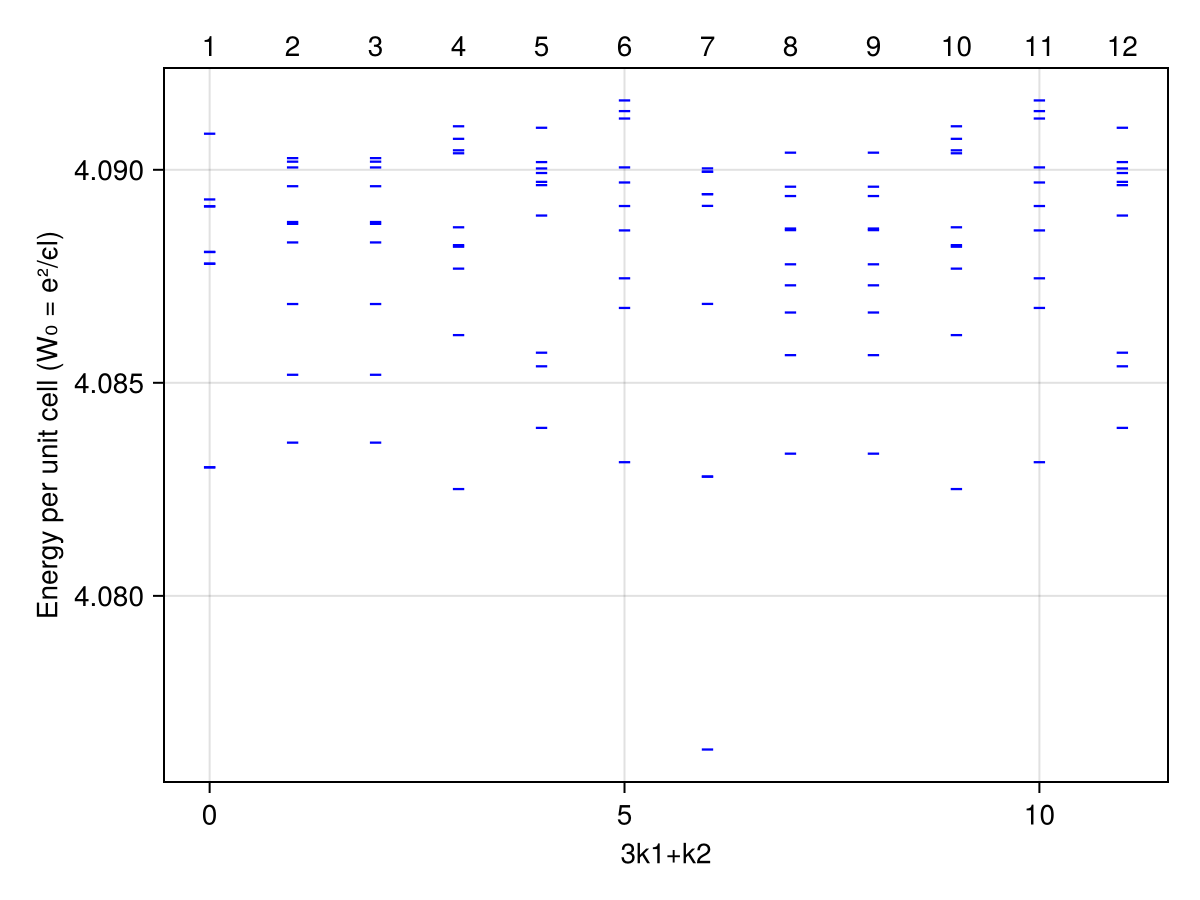

((energies[7])[1] / Nk) / LLT.W0 = 4.076393453244259
  4.544737 seconds (68.41 k allocations: 4.536 MiB)
maximum(abs.(imag.(str_fac48))) = 3.760103421920192e-18
extrema(real.(str_fac48)) = (-3.848773152033876e-15, 2.652486502495997)
str_fac48[index_shift..., 1, 2] = 2.652486502495997 + 0.0im
str_fac48[index_shift..., 2, 1] = 2.3191531691626666 + 0.0im


In [11]:
plot_ed_spectrum(energies/Nk/LLT.W0, ss_k1, ss_k2) # 4, 8
@show energies[7][1]/Nk/LLT.W0
myvec48 = vectors[7][1]
@time str_fac48 = structure_factor_expectation(myvec48);
@show maximum(abs.(imag.(str_fac48)));
@show extrema(real.(str_fac48));
@show str_fac48[index_shift..., 1,2];
@show str_fac48[index_shift..., 2,1];

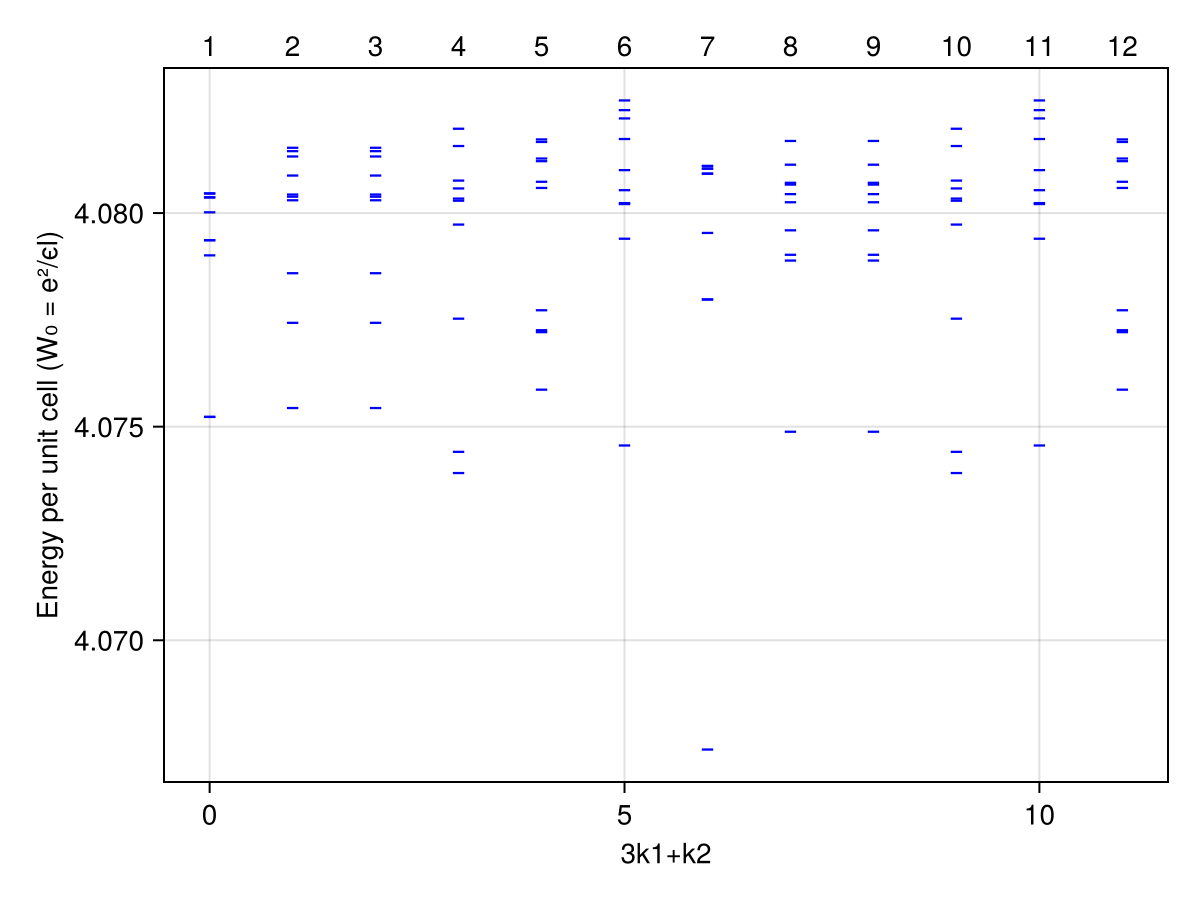

((energies[7])[1] / Nk) / LLT.W0 = 4.067442436801596
 12.425331 seconds (86.06 k allocations: 5.383 MiB, 0.30% compilation time)
maximum(abs.(imag.(str_fac57))) = 1.6624433311444402e-18
extrema(real.(str_fac57)) = (-1.521745692419548e-13, 2.7384369338235977)
str_fac57[index_shift..., 1, 2] = 2.7384369338235977 + 0.0im
str_fac57[index_shift..., 2, 1] = 2.571770267156928 + 0.0im


2.571770267156928 + 0.0im

In [57]:
plot_ed_spectrum(energies/Nk/LLT.W0, ss_k1, ss_k2) # 5, 7
@show energies[7][1]/Nk/LLT.W0
myvec57 = vectors[7][1]
@time str_fac57 = structure_factor_expectation(myvec57);
@show maximum(abs.(imag.(str_fac57)))
@show extrema(real.(str_fac57))
@show str_fac57[index_shift..., 1,2]
@show str_fac57[index_shift..., 2,1]

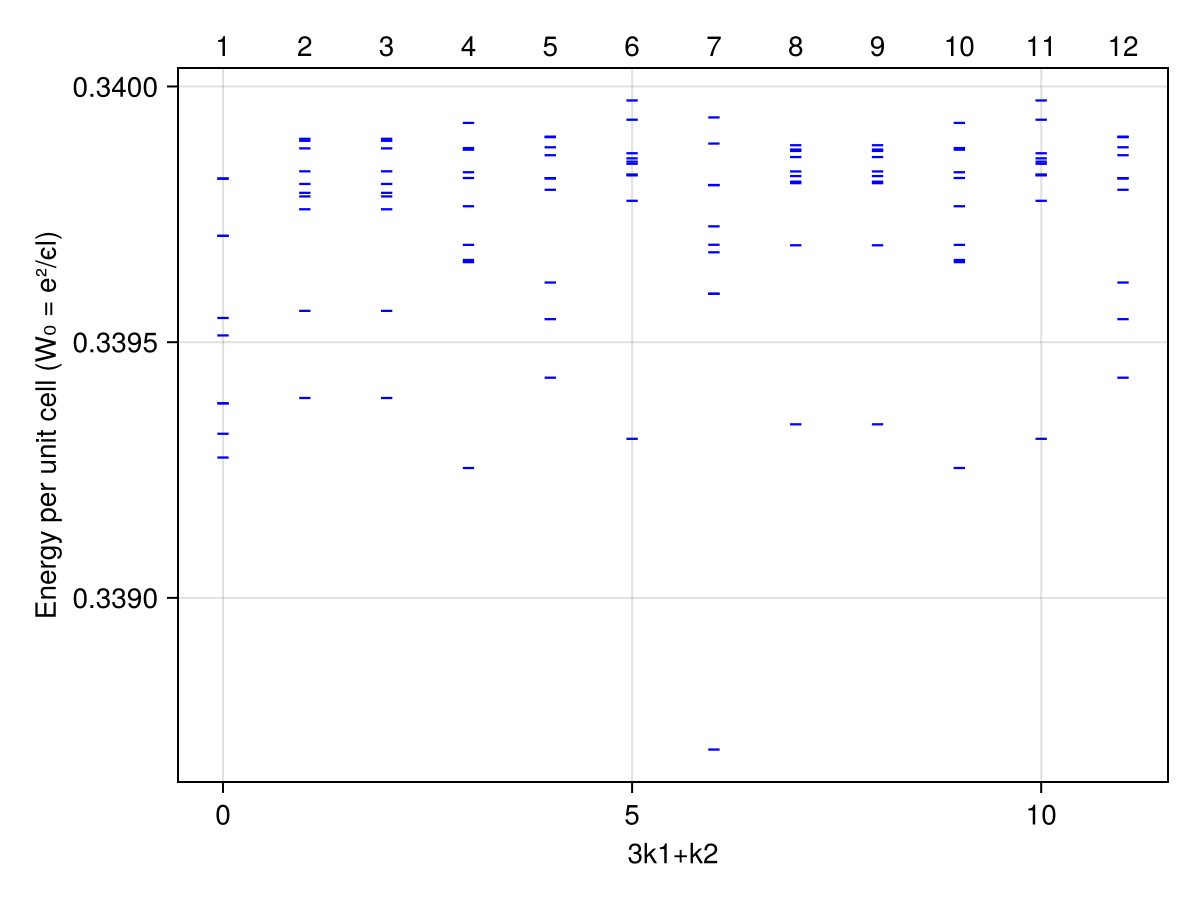

((energies[7])[1] / Nk) / LLT.W0 = 4.064439816825847
 15.947727 seconds (1.35 M allocations: 66.131 MiB, 0.09% gc time, 6.07% compilation time)
maximum(abs.(imag.(str_fac66))) = 2.219133037333943e-18
extrema(real.(str_fac66)) = (3.010800956256261e-20, 2.705757638575107)
str_fac66[index_shift..., 1, 2] = 2.705757638575107 + 0.0im
str_fac66[index_shift..., 2, 1] = 2.705757638575107 + 0.0im


2.705757638575107 + 0.0im

In [9]:
plot_ed_spectrum(energies/Nk/LLT.W0, ss_k1, ss_k2) # 6, 6
@show energies[7][1]/Nk/LLT.W0
myvec66 = vectors[7][1]
@time str_fac66 = structure_factor_expectation(myvec66);
@show maximum(abs.(imag.(str_fac66)))
@show extrema(real.(str_fac66))
@show str_fac66[index_shift..., 1,2]
@show str_fac66[index_shift..., 2,1]

Plot structure factors (when layer indices are different, it's equivalent to exciton density)

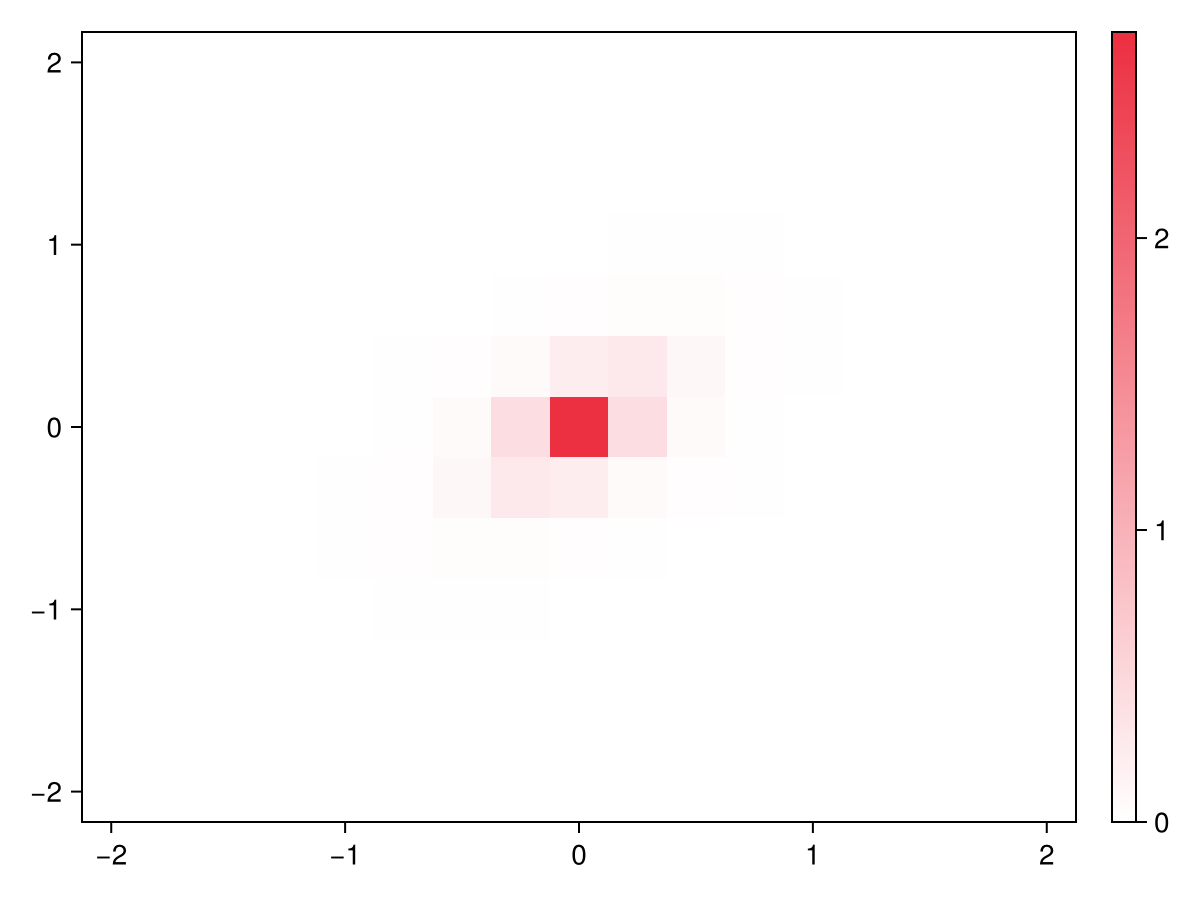

CairoMakie.Screen{IMAGE}


In [10]:
let structure_factor = str_fac66, layer = (1,2)
    fig = Figure();
    ax = Axis(fig[1,1])
    hm = heatmap!(ax, (-2Gk[1]:2Gk[1])./Gk[1], (-2Gk[2]:2Gk[2])./Gk[2], 
        real.(structure_factor[:,:,layer...]);
        colorrange = (0.0, maximum(real.(structure_factor[:,:,layer...]))),
        colormap = range(Makie.Colors.colorant"white", stop=Makie.Colors.colorant"#ec2f41", length=15)
    )
    Colorbar(fig[1, 2], hm)
    display(fig)
end

Compute one-exciton reduced density matrix and entanglement spectrum;

compute the interlayer entanglement.

In [55]:
NA = (1, -1)
ph_components = BitVector(NA .< 0)
total_particlehole_number = [ph_components[c] ? Nk - Ne[c] : Ne[c] for c in 1:Nc_conserve]
normalizer = binomial(total_particlehole_number[1], abs(NA[1])) * binomial(total_particlehole_number[2], abs(NA[2]))
# Create momentum blocks for part A (Hilbert subspace)
Ass, Ak1, Ak2 = ED_momentum_subspaces(para_conserve, NA);

sn = 7
vec = vectors[sn][1]
entanglement_spectrum = Vector{Vector{Float64}}(undef, length(Ass));
trace = 0.0; entropy = 0.0;
for i in eachindex(entanglement_spectrum)
    println("Processing subspace #$i with size $(length(Ass[i])), momentum $(Ak1[i]), $(Ak2[i])")
    rdm = PES_MomtBlock_rdm(para_conserve, vec, Ass[i], ph_components)
    vals = eigvals(rdm) #./ normalizer
    nonzero_start = findfirst(>(1e-10), vals)
    isnothing(nonzero_start) || (entanglement_spectrum[i] = -log.(vals[nonzero_start:end]))
    isnothing(nonzero_start) || (entropy += sum(λ -> -λ*log(λ), vals[nonzero_start:end]))
end
entropy = (entropy + trace * log(trace)) / trace
@show trace, entropy;

Processing subspace #1 with size 12, momentum 0, 0
Processing subspace #2 with size 12, momentum 0, 1
Processing subspace #3 with size 12, momentum 0, 2
Processing subspace #4 with size 12, momentum 1, 0
Processing subspace #5 with size 12, momentum 1, 1
Processing subspace #6 with size 12, momentum 1, 2
Processing subspace #7 with size 12, momentum 2, 0
Processing subspace #8 with size 12, momentum 2, 1
Processing subspace #9 with size 12, momentum 2, 2
Processing subspace #10 with size 12, momentum 3, 0
Processing subspace #11 with size 12, momentum 3, 1
Processing subspace #12 with size 12, momentum 3, 2
(trace, entropy) = (0.0, NaN)


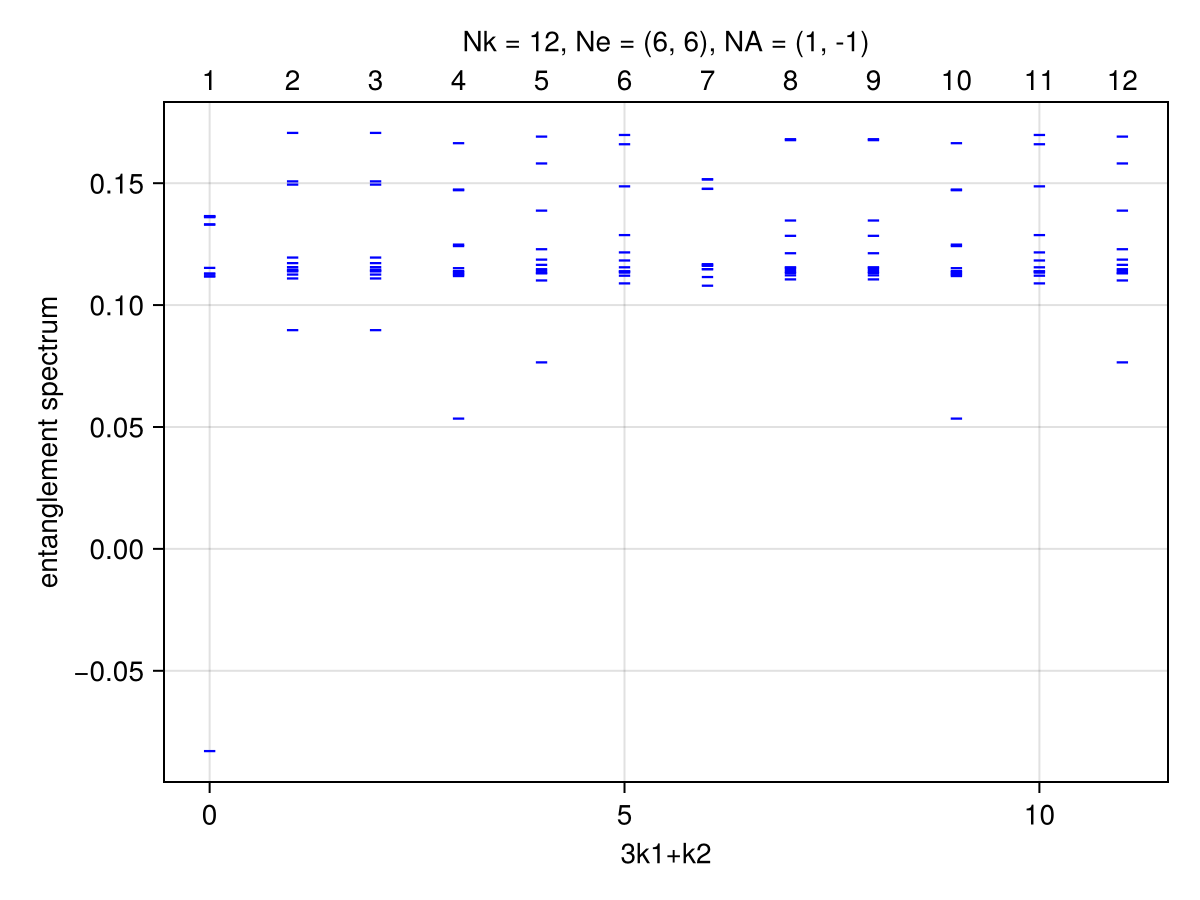

In [56]:
plot_ed_spectrum(entanglement_spectrum, Ak1, Ak2;
    ylabel = "entanglement spectrum",
    title = "Nk = $Nk, Ne = $((Ne1,Ne2)), NA = $NA",
);

In [13]:
NA = (6, 0)
ph_components = BitVector(NA .< 0)
total_particlehole_number = [ph_components[c] ? Nk - Ne[c] : Ne[c] for c in 1:Nc_conserve]
normalizer = binomial(total_particlehole_number[1], abs(NA[1])) * binomial(total_particlehole_number[2], abs(NA[2]))
# Create momentum blocks for part A (Hilbert subspace)
Ass, Ak1, Ak2 = ED_momentum_subspaces(para_conserve, NA);

sn = 7
vec = vectors[sn][1]
entanglement_spectrum = Vector{Vector{Float64}}(undef, length(Ass));
trace = 0.0; entropy = 0.0;
for i in eachindex(entanglement_spectrum)
    println("Processing subspace #$i with size $(length(Ass[i])), momentum $(Ak1[i]), $(Ak2[i])")
    rdm = PES_MomtBlock_rdm(para_conserve, vec, Ass[i], ph_components)
    vals = eigvals(rdm) ./ normalizer
    nonzero_start = findfirst(>(1e-10), vals)
    isnothing(nonzero_start) || (entanglement_spectrum[i] = -log.(vals[nonzero_start:end]))
end
entropy = (entropy + trace * log(trace)) / trace
@show trace, entropy;

Processing subspace #1 with size 76, momentum 0, 0
Processing subspace #2 with size 75, momentum 0, 1
Processing subspace #3 with size 75, momentum 0, 2
Processing subspace #4 with size 80, momentum 1, 0
Processing subspace #5 with size 78, momentum 1, 1
Processing subspace #6 with size 78, momentum 1, 2
Processing subspace #7 with size 76, momentum 2, 0
Processing subspace #8 with size 75, momentum 2, 1
Processing subspace #9 with size 75, momentum 2, 2
Processing subspace #10 with size 80, momentum 3, 0
Processing subspace #11 with size 78, momentum 3, 1
Processing subspace #12 with size 78, momentum 3, 2
(trace, entropy) = (0.0, NaN)


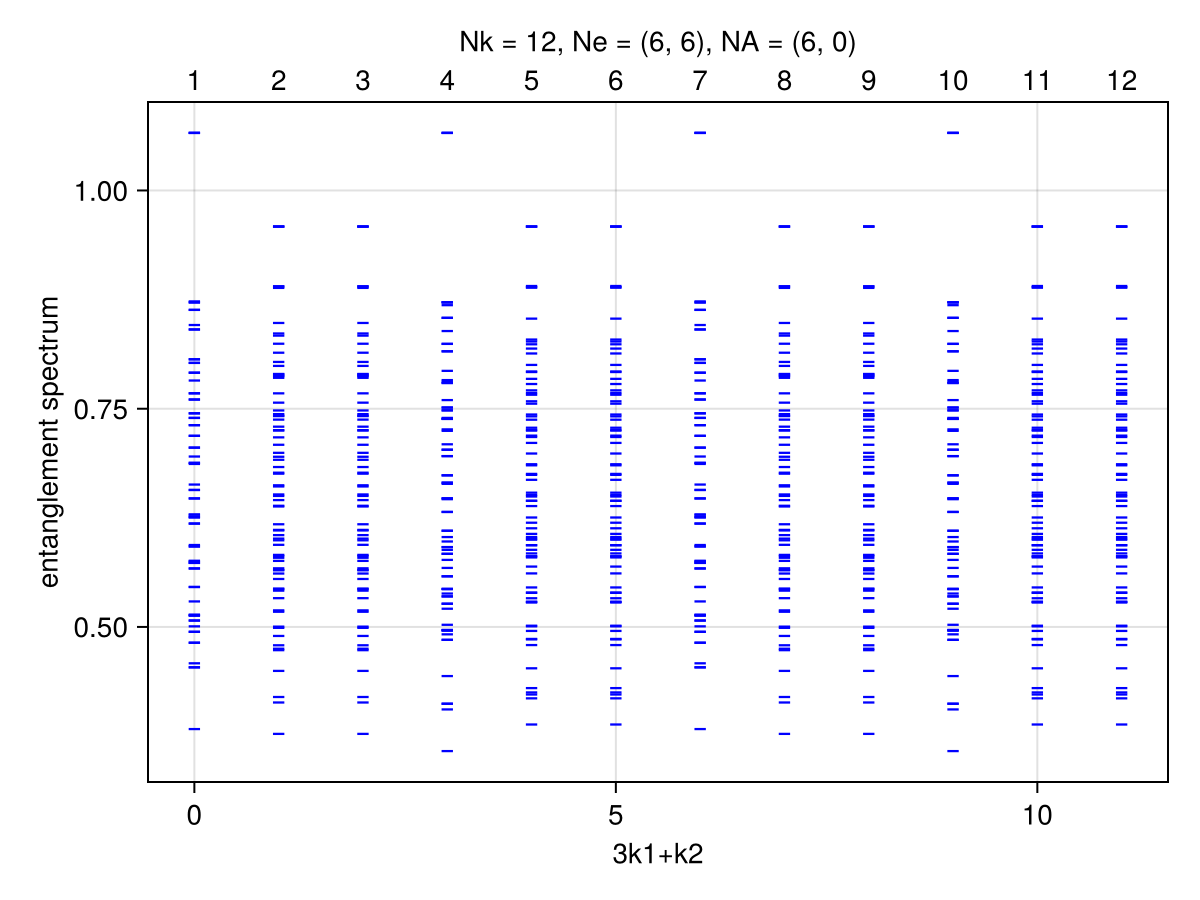

In [14]:
plot_ed_spectrum(entanglement_spectrum, Ak1, Ak2;
    ylabel = "entanglement spectrum",
    title = "Nk = $Nk, Ne = $((Ne1,Ne2)), NA = $NA",
);

Calculate inter-layer momentum shift: top and bottom layer momenta are shifted in opposite directions.

In [48]:
# layer-opposite k-shift path
Npath = 21
path = Tuple{Rational, Rational}[]
for i in 0:Npath
    push!(path, ((Npath-i)//Npath, i//Npath))
end
path

22-element Vector{Tuple{Rational, Rational}}:
 (1, 0)
 (20//21, 1//21)
 (19//21, 2//21)
 (6//7, 1//7)
 (17//21, 4//21)
 (16//21, 5//21)
 (5//7, 2//7)
 (2//3, 1//3)
 (13//21, 8//21)
 (4//7, 3//7)
 ⋮
 (8//21, 13//21)
 (1//3, 2//3)
 (2//7, 5//7)
 (5//21, 16//21)
 (4//21, 17//21)
 (1//7, 6//7)
 (2//21, 19//21)
 (1//21, 20//21)
 (0, 1)

In [49]:
sn = 7                     # subspace number
Neigen = 10
path_energies = similar(path, Vector{Float64})

for i in eachindex(path_energies)
    println("path #$i = $(path[i])")
    scat_list2_shift = ED_sortedScatterList_twobody(para_conserve, kshift = [path[i], .-path[i]]);
    path_energies[i], _ = EDsolve(subspaces[sn], scat_list2_shift, scat_list1_conserve;
        N = Neigen, showtime = true, ishermitian = true
    )
end
path_energies

path #1 = (1//1, 0//1)
  1.630426 seconds (111.09 k allocations: 1.861 GiB, 45.94% gc time)
  7.628433 seconds (35.33 k allocations: 1.111 GiB, 3.31% gc time)
path #2 = (20//21, 1//21)
  1.410492 seconds (72.13 k allocations: 1.859 GiB, 33.54% gc time)
  8.263981 seconds (31.71 k allocations: 1.234 GiB, 4.24% gc time)
path #3 = (19//21, 2//21)
  1.371605 seconds (72.13 k allocations: 1.859 GiB, 34.83% gc time)
 11.246227 seconds (35.96 k allocations: 1.807 GiB, 2.63% gc time)
path #4 = (6//7, 1//7)
  1.180310 seconds (72.13 k allocations: 1.859 GiB, 28.15% gc time)
 11.567533 seconds (35.02 k allocations: 1.680 GiB, 3.24% gc time)
path #5 = (17//21, 4//21)
  1.199738 seconds (72.12 k allocations: 1.859 GiB, 27.34% gc time)
 12.458651 seconds (37.34 k allocations: 1.682 GiB, 3.09% gc time)
path #6 = (16//21, 5//21)
  1.263423 seconds (72.12 k allocations: 1.859 GiB, 30.99% gc time)
 10.960763 seconds (33.66 k allocations: 1.489 GiB, 3.15% gc time)
path #7 = (5//7, 2//7)
  1.310947 secon

22-element Vector{Vector{Float64}}:
 [48.77327780191025, 48.901637699863855, 48.90163769986417, 48.91330625888687, 48.91542543964836, 48.920611671213166, 48.93224344177638, 48.93224344177646, 48.94392838695275, 48.95128715095306]
 [48.77681567473573, 48.88589125382524, 48.899222166191606, 48.89922216619168, 48.922967164815844, 48.936046934854794, 48.936046934854986, 48.94323582369914, 48.946582756618156, 48.950257521480246]
 [48.78727464407827, 48.85978080045903, 48.89520941866827, 48.895209418668394, 48.9296980251093, 48.94101278967286, 48.941012789673, 48.94817984042582, 48.94817984042593, 48.95174848870479]
 [48.80419196496684, 48.837489117541715, 48.8931948560287, 48.893194856028764, 48.93891977686998, 48.93997751897843, 48.93997751897847, 48.94748259650913, 48.94748259650923, 48.95059702757168]
 [48.82018157919575, 48.826798741862206, 48.89468452039166, 48.894684520391834, 48.92925780393822, 48.94086872067861, 48.94086872067871, 48.941713366405104, 48.94171336640511, 48.9454856432

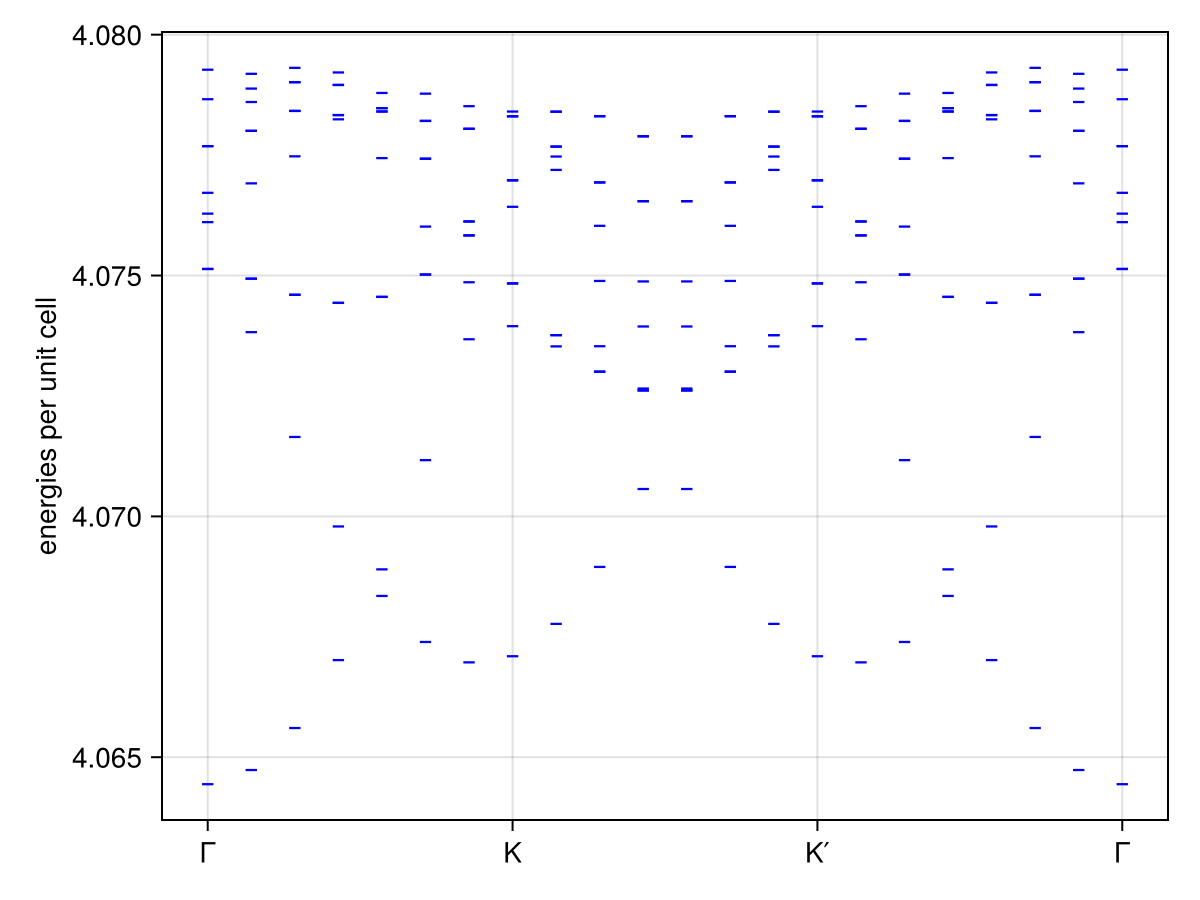

In [17]:
fig = Figure();
ax = Axis(fig[1,1];
    ylabel = "energies per unit cell",
    xticks = ([0, Npath/3, 2Npath/3, Npath], ["Γ", "K", "K′", "Γ"])
)
for (i, engs) in enumerate(path_energies)
    for e in engs
        scatter!(ax, i-1, e/Nk/LLT.W0, color = :blue, marker=:hline)
    end
end
# ylims!(4.076, 4.077)
fig

check quadratic

In [29]:
# layer-opposite k-shift path
Npath = 1000
path_k1 = Tuple{Rational, Rational}[]
path_k2 = Tuple{Rational, Rational}[]
for i in 0:5
    push!(path_k1, (i//Npath, 0//1))
    push!(path_k2, (0//1, i//Npath))
end
path_k1, path_k2

(Tuple{Rational, Rational}[(0, 0), (1//1000, 0), (1//500, 0), (3//1000, 0), (1//250, 0), (1//200, 0)], Tuple{Rational, Rational}[(0, 0), (0, 1//1000), (0, 1//500), (0, 3//1000), (0, 1//250), (0, 1//200)])

In [ ]:
sn = 7                     # subspace number
Neigen = 10
path_energies_k1 = similar(path_k1, Vector{Float64})
path_energies_k2 = similar(path_k2, Vector{Float64})

for i in eachindex(path_energies_k1)
    println("path #$i = k1: $(path_k1[i]), k2: $(path_k2[i])")
    scat_list2_shift = ED_sortedScatterList_twobody(para_conserve, kshift = [path_k1[i], .-path_k1[i]]);
    path_energies_k1[i], _ = EDsolve(subspaces[sn], scat_list2_shift, scat_list1_conserve;
        N = Neigen, showtime = true, ishermitian = true
    )
    scat_list2_shift = ED_sortedScatterList_twobody(para_conserve, kshift = [path_k2[i], .-path_k2[i]]);
    path_energies_k2[i], _ = EDsolve(subspaces[sn], scat_list2_shift, scat_list1_conserve;
        N = Neigen, showtime = true, ishermitian = true
    )
end

path #1 = (0//1, 0//1)
  1.566497 seconds (118.75 k allocations: 1.862 GiB, 40.70% gc time)
  7.751327 seconds (35.58 k allocations: 1.143 GiB, 3.36% gc time)
  1.524685 seconds (72.13 k allocations: 1.859 GiB, 42.16% gc time)
  7.691979 seconds (35.57 k allocations: 1.143 GiB, 3.22% gc time)
path #2 = (0//1, 1//1000)
  1.277677 seconds (72.13 k allocations: 1.859 GiB, 35.06% gc time)
  7.552335 seconds (35.35 k allocations: 1.111 GiB, 2.96% gc time)
  1.362817 seconds (72.13 k allocations: 1.859 GiB, 34.60% gc time)
  7.735336 seconds (35.34 k allocations: 1.111 GiB, 3.26% gc time)
path #3 = (0//1, 1//500)
  1.232541 seconds (72.12 k allocations: 1.859 GiB, 28.95% gc time)
  7.844871 seconds (35.34 k allocations: 1.111 GiB, 4.10% gc time)
  1.221013 seconds (72.13 k allocations: 1.859 GiB, 27.00% gc time)
  7.905834 seconds (35.58 k allocations: 1.143 GiB, 2.97% gc time)
path #4 = (0//1, 3//1000)
  1.293611 seconds (72.12 k allocations: 1.859 GiB, 28.55% gc time)
  7.820755 seconds (3

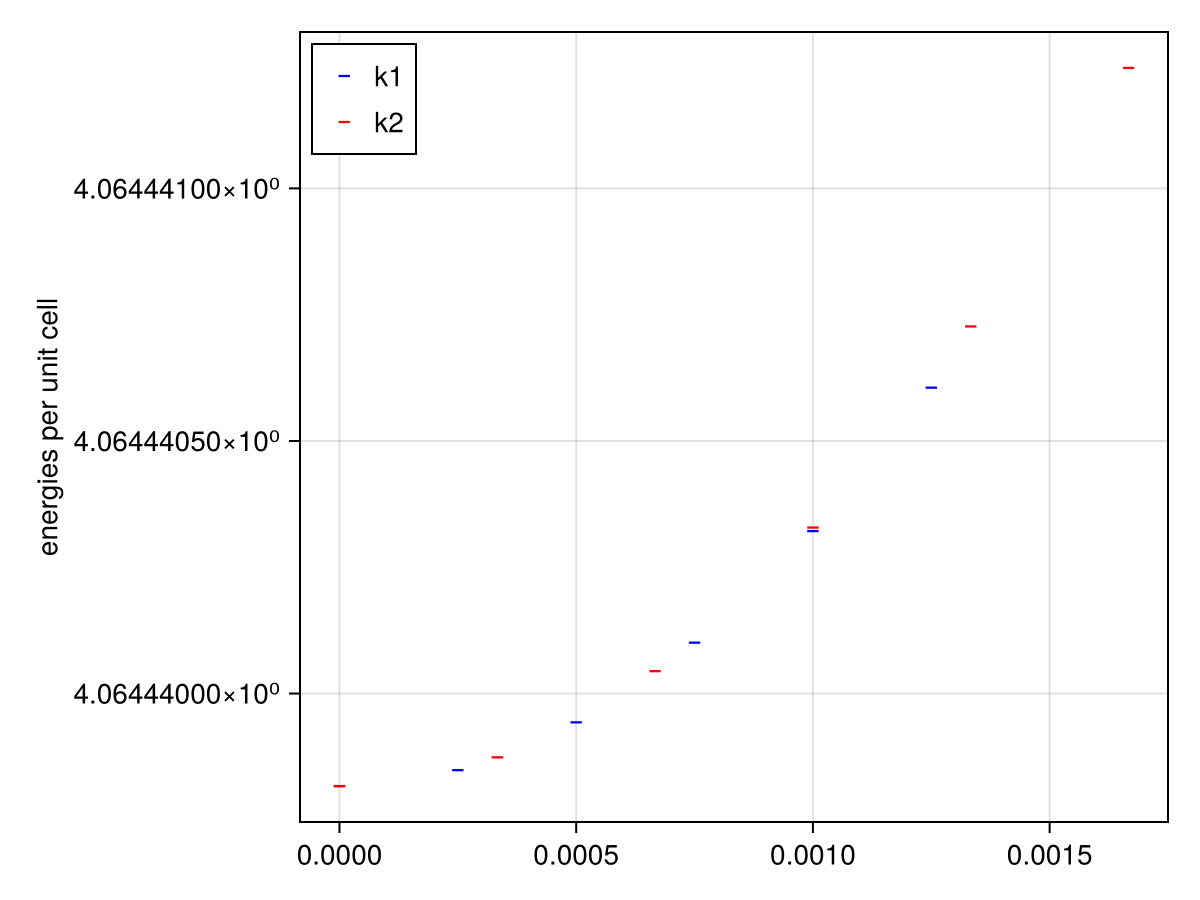

In [40]:
fig = Figure();
ax = Axis(fig[1,1];
    ylabel = "energies per unit cell",
)
for i in eachindex(path_energies_k1)
    scatter!(ax, path_k1[i][1]/Gk[1], path_energies_k1[i][1]/Nk/LLT.W0;
        color = :blue, marker=:hline, label = i==1 ? "k1" : nothing
    )
    scatter!(ax, path_k2[i][2]/Gk[2], path_energies_k2[i][1]/Nk/LLT.W0;
        color = :red, marker=:hline, label = i==1 ? "k2" : nothing
    )
end
axislegend(ax; position = :lt)
fig

In [50]:
i = 4
(path_energies_k1[i+1][1] - path_energies_k1[1][1])/(path_energies_k1[2][1] - path_energies_k1[1][1])

15.999909523923556